In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
from sklearn.preprocessing import StandardScaler

# Download Apple stock data using yfinance
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=3*365)  # 3 years of data
aapl = yf.download('AAPL', start=start_date, end=end_date)
aapl.reset_index(inplace=True)

# Select features for training
cols = ['Open', 'High', 'Low', 'Close', 'Volume']

# Extract dates for visualization
datelist_train = list(aapl['Date'])
datelist_train = [date.date() for date in datelist_train]

print('Training set shape == {}'.format(aapl.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Features selected: {}'.format(cols))

# Data preprocessing
dataset_train = aapl[cols].astype(float)

# Convert to numpy array
training_set = dataset_train.values
print('Shape of training set == {}.'.format(training_set.shape))

# Feature Scaling
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

# Create separate scaler for predictions (will be used later)
sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 3:4])  # We'll predict the Close price

# Create sequences for training
# We'll use past 90 days to predict 60 days into the future
X_train = []
y_train = []

n_future = 60   # Number of days we want to predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future + 1):
    # For X_train, we use all features
    X_train.append(training_set_scaled[i - n_past:i, :])
    # For y_train, we only predict the Close price
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 3])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

# Save scalers for later use
import joblib
joblib.dump(sc, 'full_scaler.save')
joblib.dump(sc_predict, 'predict_scaler.save')

[*********************100%%**********************]  1 of 1 completed
Training set shape == (752, 7)
All timestamps == 752
Features selected: ['Open', 'High', 'Low', 'Close', 'Volume']
Shape of training set == (752, 5).
X_train shape == (603, 90, 5).
y_train shape == (603, 1).


['predict_scaler.save']

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.embedding = layers.Dense(embed_dim)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=True):
        x = self.embedding(inputs)
        attn_output = self.att(x, x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def create_transformer_model(
    input_shape,
    head_size=64,    # 嵌入维度 增加head_size可以提升模型容量
    num_heads=4,     # 注意力头数 增加注意力头数可以捕捉更复杂的模式
    ff_dim=128,      # 前馈网络维度
    num_transformer_blocks=4,  # Transformer块的数量
    dropout=0.1,
):
    inputs = layers.Input(shape=input_shape)
    x = inputs
    
    # Transformer blocks
    for _ in range(num_transformer_blocks):
        x = TransformerEncoder(
            head_size, num_heads, ff_dim, dropout
        )(x)

    # 使用注意力机制聚合时间步信息
    query_value = layers.Dense(head_size)(x)
    attention_weights = tf.nn.softmax(layers.Dense(1)(query_value), axis=1)
    context_vector = tf.reduce_sum(x * attention_weights, axis=1)
    
    # 直接连接输出层
    outputs = layers.Dense(1)(context_vector)
    
    return tf.keras.Model(inputs, outputs)

开始快速实验...
测试基础配置
Epoch 1/20
8/8 [==============================] - 17s 673ms/step - loss: 1.6983 - mae: 1.0134 - val_loss: 0.6533 - val_mae: 0.6531
Epoch 2/20
8/8 [==============================] - 4s 533ms/step - loss: 0.5207 - mae: 0.5788 - val_loss: 0.4123 - val_mae: 0.5330
Epoch 3/20
8/8 [==============================] - 5s 582ms/step - loss: 0.3768 - mae: 0.5017 - val_loss: 0.3605 - val_mae: 0.5053
Epoch 4/20
8/8 [==============================] - 4s 501ms/step - loss: 0.3290 - mae: 0.4656 - val_loss: 0.3021 - val_mae: 0.4581
Epoch 5/20
8/8 [==============================] - 4s 473ms/step - loss: 0.2630 - mae: 0.4174 - val_loss: 0.1546 - val_mae: 0.3170
Epoch 6/20
8/8 [==============================] - 4s 520ms/step - loss: 0.1791 - mae: 0.3425 - val_loss: 0.1264 - val_mae: 0.2872
Epoch 7/20
8/8 [==============================] - 5s 459ms/step - loss: 0.1328 - mae: 0.2928 - val_loss: 0.1391 - val_mae: 0.3036
Epoch 8/20
8/8 [==============================] - 4s 465ms/step - loss: 

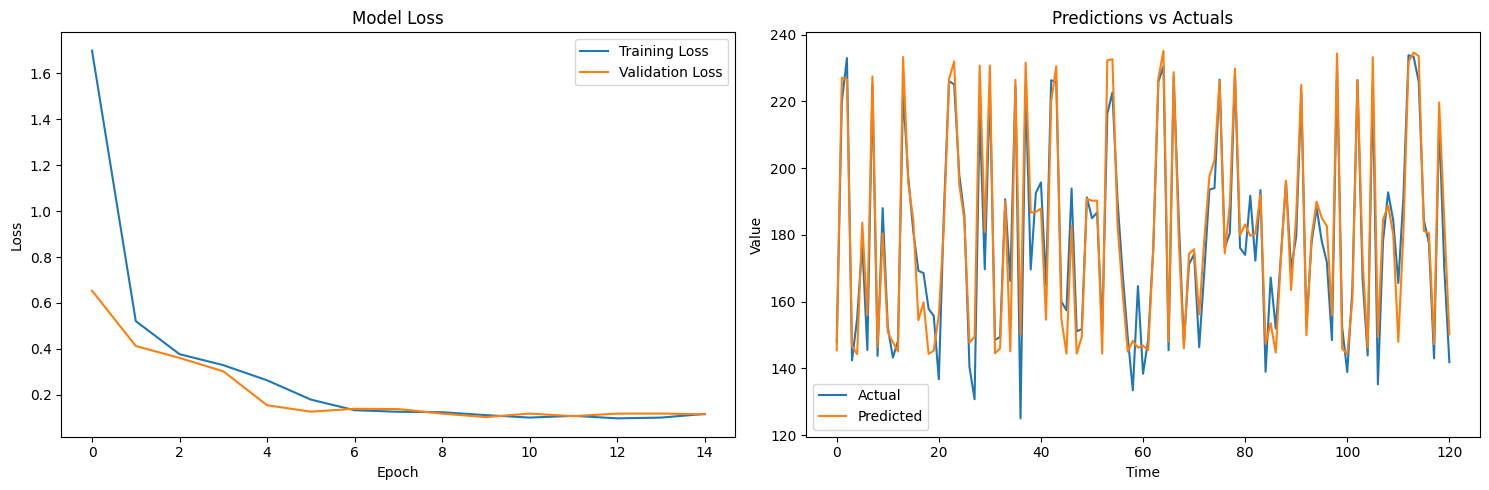

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 快速实验版本的训练函数
def quick_experiment(X_train, y_train, params, epochs=20):
    """
    epochs设置较小以快速得到结果
    """
    # 划分训练集和验证集
    X_train_data, X_val, y_train_data, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    # 创建模型
    model = create_transformer_model(
        input_shape=X_train.shape[1:],
        head_size=params['head_size'],
        num_heads=params['num_heads'],
        ff_dim=params['ff_dim'],
        num_transformer_blocks=params['num_transformer_blocks'],
        dropout=params['dropout']
    )
    
    # 编译模型
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    # 创建数据集
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_data, y_train_data))
    train_dataset = train_dataset.shuffle(1024).batch(params['batch_size'])
    
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_dataset = val_dataset.batch(params['batch_size'])
    
    # 训练模型
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        ],
        verbose=1
    )
    
    return model, history, X_val, y_val

# 快速可视化函数
def quick_plot(history, predictions=None, actuals=None):
    """
    在一张图上展示训练历史和预测结果
    """
    plt.figure(figsize=(15, 5))
    
    # 绘制训练历史
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # 如果有预测结果，绘制预测vs实际值
    if predictions is not None and actuals is not None:
        plt.subplot(1, 2, 2)
        plt.plot(actuals, label='Actual')
        plt.plot(predictions, label='Predicted')
        plt.title('Predictions vs Actuals')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# 主实验流程
def main_experiment():
    # 基础参数配置
    base_params = {
        'batch_size': 64,
        'learning_rate': 1e-3,
        'head_size': 64,
        'num_heads': 4,
        'ff_dim': 128,
        'num_transformer_blocks': 4,
        'dropout': 0.1
    }
    
    print("测试基础配置")
    model, history, X_val, y_val = quick_experiment(X_train, y_train, base_params)
    predictions = model.predict(X_val)
    predictions = sc_predict.inverse_transform(predictions)
    y_val_inverse = sc_predict.inverse_transform(y_val)
    quick_plot(history, predictions, y_val_inverse)

if __name__ == "__main__":
    print("开始快速实验...")
    main_experiment()

损失曲线分析:

训练损失和验证损失都在良好下降，说明模型在学习
两条曲线比较接近，没有明显的过拟合现象
在epoch 6之后趋于平稳，说明模型基本收敛
验证损失没有明显上升，说明当前的正则化参数（dropout=0.1）基本合适


预测效果分析:

预测值（橙色）基本能跟随实际值（蓝色）的趋势
但预测曲线比实际值更平滑，说明模型可能还没有完全捕捉到短期波动
有些峰值预测不够准确，说明模型对极端情况的预测能力还可以提升